<a href="https://colab.research.google.com/github/sjamillah/Wildlife_Corridors_project/blob/main/HMM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov Model (HMM) Analysis of Animal Movement

This notebook demonstrates how to use Hidden Markov Models (HMMs) to analyze animal tracking data and identify different behavioral states. The process involves loading and cleaning data, preparing it for HMM training, selecting the optimal number of hidden states, training the HMM, interpreting the states, and visualizing the results.

### Install Libraries

This cell installs the `hmmlearn` library, which is required for building and training the Hidden Markov Model.

In [ ]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.6 MB/s eta 0:00:00


### Import Libraries

This cell imports all the necessary Python libraries, including `numpy`, `pandas`, `matplotlib`, `seaborn`, `hmmlearn`, `scikit-learn`, and `scipy`. It also sets a random seed for reproducibility and suppresses warnings.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

import random
np.random.seed(42)
random.seed(42)

### Load and Clean Data

This function `load_and_clean_tracking_data` is designed to load raw GPS tracking data from a specified filepath. It includes robust error handling for file operations and performs several cleaning steps:
- Strips whitespace from column names.
- Checks for required columns (`step_length`, `turning_angle`, `individual-local-identifier`).
- Converts `step_length` and `turning_angle` to numeric, coercing errors to NaN.
- Removes rows with NaN values in essential columns.
- Filters out rows with negative `step_length`.
- Converts `turning_angle` from degrees to radians and normalizes it to the range [-π, π].
- Assigns a default `time_diff` if timestamps are missing.
- Assigns a default species if missing.
- Processes timestamps if available, attempting various formats and calculating `time_diff` in hours.
- Calculates `speed` based on `step_length` and `time_diff`, handling potential division by zero and capping unrealistic speeds.
- Prints summaries of the data loading and cleaning process.

In [ ]:
def load_and_clean_tracking_data(filepath):
    """
    Load and clean raw GPS tracking data with robust error handling.
    """
    print(f"\nLoading data from: {filepath}")

    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"ERROR: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"ERROR: Failed to load file due to {str(e)}")
        return None

    df.columns = df.columns.str.strip()

    print(f"Initial observations: {len(df)}")
    print(f"Columns: {df.columns.tolist()}")

    required_cols = ['step_length', 'turning_angle', 'individual-local-identifier']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"ERROR: Missing required columns: {missing_cols}")
        return None

    initial_len = len(df)

    for col in ['step_length', 'turning_angle']:
        before = len(df)
        df[col] = pd.to_numeric(df[col], errors='coerce')
        after_convert = len(df[df[col].notna()])
        print(f"  {col}: {before} to {after_convert} valid values ({before - after_convert} NaN)")

    df = df.dropna(subset=['step_length', 'turning_angle'])
    print(f"After removing NaN: {len(df)} ({initial_len - len(df)} removed)")

    before_step = len(df)
    df = df[df['step_length'] >= 0]
    print(f"After step_length >= 0: {len(df)} ({before_step - len(df)} removed)")

    print("Converting turning_angle from degrees to radians (manual conversion)")
    df['turning_angle'] = np.radians(df['turning_angle'])


    df['turning_angle'] = np.arctan2(np.sin(df['turning_angle']), np.cos(df['turning_angle']))

    print(f"Turning angle range: [{df['turning_angle'].min():.4f}, {df['turning_angle'].max():.4f}] radians")

    if 'timestamp' not in df.columns:
        print("Warning: Missing timestamp column — assigning constant time_diff = 1.0")
        df['time_diff'] = 1.0
    if 'species' not in df.columns:
        df['species'] = 'unknown'

    if 'timestamp' in df.columns:
        print(f"\nProcessing timestamps...")
        print(f"  Sample timestamps: {df['timestamp'].head(3).tolist()}")

        if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
            date_formats = [
                '%Y-%m-%d %H:%M:%S',
                '%Y-%m-%d %H:%M:%S.%f',
                '%d/%m/%Y %H:%M:%S',
                '%m/%d/%Y %H:%M:%S',
                '%Y-%m-%dT%H:%M:%S',
                '%Y-%m-%dT%H:%M:%SZ'
            ]

            parsed = False
            for fmt in date_formats:
                try:
                    df['timestamp'] = pd.to_datetime(df['timestamp'], format=fmt)
                    parsed = True
                    print(f"  Successfully parsed with format: {fmt}")
                    break
                except:
                    continue

            if not parsed:
                df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
                print(f"  Parsed with automatic format detection")

            valid_timestamps = df['timestamp'].notna().sum()
            df = df.dropna(subset=['timestamp'])
            print(f"  Valid timestamps: {valid_timestamps}/{len(df) + (initial_len - len(df))}")

        df = df.sort_values(['individual-local-identifier', 'timestamp'])

        df['time_diff'] = df.groupby('individual-local-identifier')['timestamp'].diff().dt.total_seconds() / 3600

        # Fill NaN time_diff values (first observation for each animal) with 0 then clip to avoid zero
        df['time_diff'] = df['time_diff'].fillna(0)
        df['time_diff'] = df['time_diff'].clip(lower=1e-3)

        print(f"  Time difference stats (hours):")
        print(f"    Mean: {df['time_diff'].mean():.2f}")
        print(f"    Median: {df['time_diff'].median():.2f}")
        print(f"    Range: [{df['time_diff'].min():.2f}, {df['time_diff'].max():.2f}]")

    # Stabilize speed calculation: ensure time_diff never approaches zero and compute speed
    if 'time_diff' in df.columns:
        df['time_diff'] = df['time_diff'].clip(lower=1e-3)
    if 'step_length' in df.columns and 'time_diff' in df.columns:
        with np.errstate(divide='ignore', invalid='ignore'):
            df['speed'] = np.where(df['time_diff'] > 0, df['step_length'] / df['time_diff'], np.nan)
        df.loc[df['speed'] > 120, 'speed'] = np.nan

    print(f"\nFinal dataset: {len(df)} observations")
    return df

### Prepare HMM Sequences

This function `prepare_hmm_sequences` takes the cleaned DataFrame and prepares the data for HMM training. It structures the data into sequences for each individual animal:
- Iterates through unique animal identifiers.
- Skips animals with fewer than 10 observations.
- Creates sine and cosine components of the `turning_angle` for cyclical data representation.
- Selects features (`step_length`, `sin_angle`, `cos_angle`, `time_diff`) to be used in the HMM.
- Appends the feature sequences and their lengths to lists.
- Stacks all sequences into a single feature matrix `X` for training.
- Returns the feature matrix, sequence lengths, animal IDs, individual sequences, and species list.

In [ ]:
def prepare_hmm_sequences(df, species=None):
    """
    Prepare individual animal sequences for HMM training.

    Parameters:
    -----------
    df : DataFrame
        Wildlife tracking data
    species : str, optional
        Species identifier (e.g., 'elephant', 'wildebeest')
    """
    sequences = []
    lengths = []
    animal_ids = []
    species_list = []

    for animal_id in df['individual-local-identifier'].unique():
        animal_data = df[df['individual-local-identifier'] == animal_id].copy()

        if len(animal_data) < 10:
            print(f"  Skipping {animal_id}: only {len(animal_data)} observations (min 10 required)")
            continue

        animal_data['sin_angle'] = np.sin(animal_data['turning_angle'])
        animal_data['cos_angle'] = np.cos(animal_data['turning_angle'])
        features = animal_data[['step_length', 'sin_angle', 'cos_angle', 'time_diff']].values

        sequences.append(features)
        lengths.append(len(features))
        animal_ids.append(animal_id)
        species_list.append(species)

    if len(sequences) == 0:
        print("ERROR: No valid sequences found!")
        return None, None, None, None, None

    X = np.vstack(sequences)

    print(f"\nPrepared {len(sequences)} animal sequences")
    print(f"Total observations: {len(X)}")
    print(f"Sequence lengths: min={min(lengths)}, max={max(lengths)}, mean={np.mean(lengths):.1f}")

    return X, lengths, animal_ids, sequences, species_list

### Initialize HMM Parameters

This function `initialize_hmm_parameters` initializes the starting parameters for the HMM (means, covariances, transition matrix, and start probabilities). It uses K-Means clustering on the feature data to get initial estimates for the means and variances of each hidden state, which helps in stabilizing the HMM training process and avoiding issues with the transition matrix initialization.

In [ ]:
def initialize_hmm_parameters(X, n_states):
    """
    Initialize HMM parameters using k-means clustering to avoid transition matrix issues.
    """

    kmeans = KMeans(n_clusters=n_states, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    means = np.zeros((n_states, X.shape[1]))
    covars = np.zeros((n_states, X.shape[1]))

    for i in range(n_states):
        state_data = X[labels == i]
        if len(state_data) > 0:
            means[i] = state_data.mean(axis=0)
            covars[i] = state_data.var(axis=0) + 1e-6
        else:
            means[i] = X.mean(axis=0)
            covars[i] = X.var(axis=0) + 1e-6

    transmat = np.full((n_states, n_states), 0.05)
    np.fill_diagonal(transmat, 0.95 - (0.05 * (n_states - 1)))
    transmat = transmat / transmat.sum(axis=1, keepdims=True)

    startprob = np.ones(n_states) / n_states

    return means, covars, transmat, startprob

### Prepare Data for HMM

This cell separates the combined data back into species-specific DataFrames. It then calls the `prepare_hmm_sequences` function for each species to extract the feature sequences and their corresponding lengths and animal IDs. Finally, it combines the sequences, lengths, and IDs from both species into unified variables (`X`, `lengths`, `animal_ids`, `sequences`).

In [ ]:
def fit_hmm_with_regularization(X, lengths, n_states, n_attempts=5):
    """
    Fit HMM with multiple attempts and regularization to handle transition matrix issues.
    """
    best_model = None
    best_score = float('-inf')

    for attempt in range(n_attempts):
        try:
            means, covars, transmat, startprob = initialize_hmm_parameters(X, n_states)

            if attempt > 0:
                means += np.random.randn(*means.shape) * 0.01
                covars += np.random.rand(*covars.shape) * 0.001

            model = hmm.GaussianHMM(
                n_components=n_states,
                covariance_type="diag",
                n_iter=300,
                random_state=42 + attempt,
                verbose=False,
                init_params="",
                params="stmc",
                tol=1e-2
            )

            model.means_ = means
            model.covars_ = covars
            model.transmat_ = transmat
            model.startprob_ = startprob

            model.fit(X, lengths)

            if np.any(model.transmat_.sum(axis=1) < 0.99):
                continue

            score = model.score(X, lengths)

            if score > best_score and model.monitor_.converged:
                best_score = score
                best_model = model

        except Exception as e:
            continue

    return best_model

In [ ]:
def select_optimal_states(X, lengths, max_states=5):
    """
    Use AIC and BIC to select optimal number of behavioral states.
    Tests models from 2 to max_states and selects best based on BIC.
    """
    print("\nMODEL SELECTION: Testing different numbers of states")
    print("Note: Higher states may be skipped if they cannot be reliably estimated")

    results = []
    models = {}

    for n_states in range(2, max_states + 1):
        print(f"\nTesting {n_states} states (attempting multiple initializations)...")

        model = fit_hmm_with_regularization(X, lengths, n_states, n_attempts=10)

        if model is None:
            print(f"  Could not fit {n_states} states reliably, skipping")
            continue

        try:
            log_likelihood = model.score(X, lengths)
            n_params = n_states * n_states + n_states * X.shape[1] * 2

            aic = -2 * log_likelihood + 2 * n_params
            bic = -2 * log_likelihood + n_params * np.log(len(X))

            results.append({
                'n_states': n_states,
                'log_likelihood': log_likelihood,
                'aic': aic,
                'bic': bic,
                'converged': model.monitor_.converged
            })

            models[n_states] = model

            print(f"  Success! LogLik: {log_likelihood:.2f} | AIC: {aic:.2f} | BIC: {bic:.2f}")

        except Exception as e:
            print(f"  Failed to score {n_states} states: {str(e)}")
            continue

    if len(results) == 0:
        print("ERROR: All models failed to fit!")
        return None, 2

    results_df = pd.DataFrame(results)

    optimal_idx = results_df['bic'].idxmin()
    optimal_n_states = results_df.loc[optimal_idx, 'n_states']

    print(f"\nOPTIMAL MODEL: {optimal_n_states} states (lowest BIC)")
    print(f"Successfully fit {len(results)} model(s) out of {max_states - 1} attempted")

    return results_df, optimal_n_states


In [ ]:
def train_hmm_model(X, lengths, n_states):
    """
    Train the final HMM model with selected number of states.
    """
    print(f"\nTRAINING FINAL MODEL: {n_states} behavioral states")

    means, covars, transmat, startprob = initialize_hmm_parameters(X, n_states)

    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="diag",
        n_iter=200,
        random_state=42,
        tol=1e-4,
        verbose=True,
        init_params="",
        params="stmc"
    )

    model.means_ = means
    model.covars_ = covars
    model.transmat_ = transmat
    model.startprob_ = startprob

    model.fit(X, lengths)

    print(f"\nModel converged: {model.monitor_.converged}")
    print(f"Final log likelihood: {model.score(X, lengths):.2f}")
    print(f"Number of iterations: {model.monitor_.iter}")

    return model

In [ ]:
def interpret_behavioral_states(model, X, n_states, species_list=None, animal_ids=None, lengths=None):
    """
    Interpret biological meaning of discovered states with SPECIES-SPECIFIC thresholds.

    Parameters:
    -----------
    model : GaussianHMM
        Trained HMM model
    X : array
        Feature matrix
    n_states : int
        Number of behavioral states
    species_list : list
        Species identifier for each sequence
    animal_ids : list
        Animal identifiers
    lengths : list
        Length of each sequence
    """
    print(f"\nBEHAVIORAL STATE INTERPRETATION (Species-Specific Thresholds)")

    predicted_states = model.predict(X)

    unique_species = set([s for s in species_list if s is not None])
    is_mixed_species = len(unique_species) > 1

    if is_mixed_species:
        print(f"\nMIXED SPECIES DETECTED: {', '.join(unique_species)}")
        print("Using species-specific thresholds for state interpretation")

    state_stats = []
    for state in range(n_states):
        state_data = X[predicted_states == state]

        if len(state_data) > 0:
            mean_step = state_data[:, 0].mean()
            std_step = state_data[:, 0].std()
            median_step = np.median(state_data[:, 0])
            mean_angle = state_data[:, 1].mean()
            abs_mean_angle = np.abs(state_data[:, 1]).mean()
            std_angle = state_data[:, 1].std()
            count = len(state_data)

            state_stats.append({
                'state': state,
                'mean_step_length': mean_step,
                'median_step_length': median_step,
                'std_step_length': std_step,
                'mean_turning_angle': mean_angle,
                'abs_mean_turning_angle': abs_mean_angle,
                'std_turning_angle': std_angle,
                'n_observations': count,
                'percentage': (count / len(X)) * 100
            })

    stats_df = pd.DataFrame(state_stats)
    stats_df['movement_index'] = stats_df['mean_step_length'] * (1 - stats_df['abs_mean_turning_angle'])
    stats_df = stats_df.sort_values('movement_index').reset_index(drop=True)

    if len(stats_df) <= 3:
        behavior_names = ['Resting', 'Foraging', 'Migrating']
        state_labels = behavior_names[:len(stats_df)]
    else:
        state_labels = [f'State {i+1} (Intensity)' for i in range(len(stats_df))]

    if len(set(state_labels)) < len(state_labels):
        print("\nMultiple states with similar characteristics detected")
        print("   Refining labels based on step length ranking...")

        if n_states == 2:
            state_labels = ['Resting', 'Migrating']
        elif n_states == 3:
            state_labels = ['Resting', 'Foraging', 'Migrating']
        elif n_states == 4:
            state_labels = ['Resting', 'Foraging', 'Traveling', 'Migrating']
        else:
            state_labels = [f'State {i+1} (Intensity)' for i in range(n_states)]

    stats_df['state_label'] = state_labels
    state_mapping = dict(zip(stats_df['state'].values, state_labels))

    print("DISCOVERED BEHAVIORAL STATES (Species-Specific Interpretation):")

    for idx, row in stats_df.iterrows():
        print(f"\n{row['state_label'].upper()}")
        print(f"  Step Length: {row['mean_step_length']:.3f} ± {row['std_step_length']:.3f} km")
        print(f"  Turning Angle: {row['abs_mean_turning_angle']:.3f} ± {row['std_turning_angle']:.3f} rad")
        print(f"  Observations: {row['n_observations']:,} ({row['percentage']:.1f}%)")

        if 'Resting' in row['state_label']:
            print(f" Interpretation: Stationary/minimal movement (resting, drinking, feeding in place)")
        elif 'Foraging' in row['state_label']:
            print(f" Interpretation: Area-restricted search, active foraging with moderate movement")
        elif 'Migrating' in row['state_label']:
            print(f" Interpretation: Directional long-distance movement, migration or transit")
        elif 'Traveling' in row['state_label']:
            print(f" Interpretation: Medium-distance movement between resources")

    if n_states > 3:
        print("\nGrouping similar states into 3 main behavioral categories (species-specific)...")
        species = None
        if species_list and len(set(species_list)) == 1:
            species = list(set(species_list))[0]

        stats_df['behavior_group'] = pd.qcut(
            stats_df['movement_index'], 3,
            labels=['Resting', 'Foraging', 'Migrating']
        )

        print(stats_df[['state', 'mean_step_length', 'abs_mean_turning_angle', 'movement_index', 'behavior_group']])


    plt.figure(figsize=(6,4))
    plt.scatter(stats_df['mean_step_length'], stats_df['abs_mean_turning_angle'], c=range(len(stats_df)), cmap='viridis')
    for i, row in stats_df.iterrows():
        plt.text(row['mean_step_length'], row['abs_mean_turning_angle'], row['behavior_group'] if 'behavior_group' in stats_df.columns else '', fontsize=8)
    plt.xlabel("Mean Step Length")
    plt.ylabel("Abs Mean Turning Angle")
    plt.title("State Clustering by Movement Pattern")
    plt.show()

    return stats_df, predicted_states, state_mapping

In [ ]:
def analyze_state_transitions(model, stats_df):
    """
    Analyze and interpret state transition probabilities.
    """
    print(f"\nSTATE TRANSITION ANALYSIS")

    trans_mat = model.transmat_
    labels = stats_df['state_label'].tolist()

    trans_df = pd.DataFrame(trans_mat, columns=labels, index=labels)

    print("\nTransition Probability Matrix:")
    print(trans_df.round(3))

    print("\nKey Transition Patterns:")
    for i, from_state in enumerate(labels):
        for j, to_state in enumerate(labels):
            prob = trans_mat[i, j]
            if i != j and prob > 0.1:
                print(f"  {from_state} to {to_state}: {prob:.1%}")

    print("\nState Persistence (probability of staying in same state):")
    for i, state in enumerate(labels):
        print(f"  {state}: {trans_mat[i, i]:.1%}")

    return trans_df

In [ ]:
def decode_individual_sequences(model, sequences, animal_ids):
    """
    Decode state sequences for individual animals.
    """
    print(f"\nDECODING INDIVIDUAL ANIMAL SEQUENCES")

    individual_states = {}

    for seq, animal_id in zip(sequences, animal_ids):
        states = model.predict(seq)
        individual_states[animal_id] = states

        unique, counts = np.unique(states, return_counts=True)
        state_props = dict(zip(unique, counts / len(states)))

        print(f"\n{animal_id}:")
        print(f"  Observations: {len(states)}")
        for state, prop in sorted(state_props.items()):
            print(f"  State {state}: {prop:.1%}")

    return individual_states

In [ ]:
def calculate_model_performance(model, X, lengths):
    """
    Calculate comprehensive model performance metrics.
    """
    print(f"\nMODEL PERFORMANCE METRICS")

    log_likelihood = model.score(X, lengths)

    per_sample_ll = log_likelihood / len(X)

    perplexity = np.exp(-per_sample_ll)

    n_states = model.n_components
    n_params = n_states * n_states + n_states * X.shape[1] * 2

    aic = -2 * log_likelihood + 2 * n_params
    bic = -2 * log_likelihood + n_params * np.log(len(X))

    print(f"\nLog Likelihood: {log_likelihood:.2f}")
    print(f"Per-sample LL: {per_sample_ll:.4f}")
    print(f"Perplexity: {perplexity:.4f}")
    print(f"AIC: {aic:.2f}")
    print(f"BIC: {bic:.2f}")
    print(f"Number of parameters: {n_params}")
    print(f"Converged: {model.monitor_.converged}")

    return {
        'log_likelihood': log_likelihood,
        'per_sample_ll': per_sample_ll,
        'perplexity': perplexity,
        'aic': aic,
        'bic': bic,
        'n_params': n_params,
        'converged': model.monitor_.converged
    }

### Generate True Behavior Labels

This function `generate_true_behavior_labels` creates a simplified set of 'true' behavioral labels (Resting, Foraging, Migrating) based solely on predefined step length thresholds. This function is used here for demonstration purposes to provide a baseline "ground truth" for validating the HMM's state classifications using the confusion matrix. **Note:** In a real-world scenario, true labels would typically come from expert annotations or independent data sources, not simple thresholds on the same data used for HMM training.

In [ ]:
def visualize_model_results(model, X, predicted_states, stats_df, results_df):
    """
    Create comprehensive visualizations of HMM results.
    """
    print(f"\nGenerating visualizations...")

    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

    n_states = model.n_components
    state_colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#3498db'][:n_states]
    labels = stats_df['state_label'].tolist()

    ax1 = fig.add_subplot(gs[0, :2])
    for state in range(n_states):
        mask = predicted_states == state
        ax1.scatter(X[mask, 0], X[mask, 1], c=state_colors[state],
                   label=labels[state], alpha=0.4, s=15)
    ax1.set_xlabel('Step Length (km)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Turning Angle (radians)', fontsize=12, fontweight='bold')
    ax1.set_title('Behavioral State Space', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', framealpha=0.95, fontsize=10)
    ax1.grid(True, alpha=0.3)

    ax2 = fig.add_subplot(gs[0, 2])
    state_counts = [np.sum(predicted_states == s) for s in range(n_states)]
    ax2.pie(state_counts, labels=labels, colors=state_colors,
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
    ax2.set_title('State Distribution', fontsize=14, fontweight='bold')

    ax3 = fig.add_subplot(gs[1, 0])
    for state in range(n_states):
        steps = X[predicted_states == state, 0]
        ax3.hist(steps, bins=50, alpha=0.6, color=state_colors[state],
                label=labels[state], density=True)
    ax3.set_xlabel('Step Length (km)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax3.set_title('Step Length by State', fontsize=13, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    ax4 = fig.add_subplot(gs[1, 1])
    for state in range(n_states):
        angles = X[predicted_states == state, 1]
        ax4.hist(angles, bins=50, alpha=0.6, color=state_colors[state],
                label=labels[state], density=True)
    ax4.set_xlabel('Turning Angle (radians)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax4.set_title('Turning Angle by State', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    ax5 = fig.add_subplot(gs[1, 2])
    trans_mat = model.transmat_
    sns.heatmap(trans_mat, annot=True, fmt='.3f', cmap='YlOrRd',
                xticklabels=labels, yticklabels=labels, ax=ax5,
                cbar_kws={'label': 'Probability'}, vmin=0, vmax=1)
    ax5.set_title('State Transition Matrix', fontsize=13, fontweight='bold')
    ax5.set_xlabel('To State', fontsize=11, fontweight='bold')
    ax5.set_ylabel('From State', fontsize=11, fontweight='bold')

    ax6 = fig.add_subplot(gs[2, :])
    ax6.plot(results_df['n_states'], results_df['aic'], marker='o', linewidth=2.5,
            markersize=10, label='AIC', color='#3498db')
    ax6.plot(results_df['n_states'], results_df['bic'], marker='s', linewidth=2.5,
            markersize=10, label='BIC', color='#e74c3c')
    ax6.set_xlabel('Number of States', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Information Criterion', fontsize=12, fontweight='bold')
    ax6.set_title('Model Selection Criteria (Lower is Better)', fontsize=14, fontweight='bold')
    ax6.legend(fontsize=11, loc='best')
    ax6.grid(True, alpha=0.3)
    ax6.set_xticks(results_df['n_states'])

    ax7 = fig.add_subplot(gs[3, 0])
    x_pos = np.arange(n_states)
    ax7.bar(x_pos, stats_df['mean_step_length'], color=state_colors, alpha=0.7)
    ax7.set_xlabel('Behavioral State', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Mean Step Length (km)', fontsize=11, fontweight='bold')
    ax7.set_title('Average Movement Distance', fontsize=13, fontweight='bold')
    ax7.set_xticks(x_pos)
    ax7.set_xticklabels(labels, rotation=0)
    ax7.grid(True, alpha=0.3, axis='y')

    ax8 = fig.add_subplot(gs[3, 1])
    ax8.bar(x_pos, stats_df['abs_mean_turning_angle'], color=state_colors, alpha=0.7)
    ax8.set_xlabel('Behavioral State', fontsize=11, fontweight='bold')
    ax8.set_ylabel('Mean |Turning Angle| (rad)', fontsize=11, fontweight='bold')
    ax8.set_title('Path Tortuosity', fontsize=13, fontweight='bold')
    ax8.set_xticks(x_pos)
    ax8.set_xticklabels(labels, rotation=0)
    ax8.grid(True, alpha=0.3, axis='y')

    ax9 = fig.add_subplot(gs[3, 2])
    ax9.bar(x_pos, stats_df['n_observations'], color=state_colors, alpha=0.7)
    ax9.set_xlabel('Behavioral State', fontsize=11, fontweight='bold')
    ax9.set_ylabel('Number of Observations', fontsize=11, fontweight='bold')
    ax9.set_title('Sample Size per State', fontsize=13, fontweight='bold')
    ax9.set_xticks(x_pos)
    ax9.set_xticklabels(labels, rotation=0)
    ax9.grid(True, alpha=0.3, axis='y')

    plt.savefig('hmm_analysis_results.png', dpi=300, bbox_inches='tight')
    print("Saved: hmm_analysis_results.png")
    plt.show()

In [ ]:
def visualize_individual_tracks(sequences, individual_states, animal_ids, stats_df, state_mapping, n_display=3):
    """
    Visualize state sequences for individual animals.
    """
    n_states = len(stats_df)
    state_colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#3498db'][:n_states]
    labels = stats_df['state_label'].tolist()

    n_animals = min(n_display, len(sequences))

    fig, axes = plt.subplots(n_animals, 1, figsize=(18, 5 * n_animals))
    if n_animals == 1:
        axes = [axes]

    for idx in range(n_animals):
        animal_id = animal_ids[idx]
        seq = sequences[idx]
        states = individual_states[animal_id]

        ax = axes[idx]

        for state in range(n_states):
            mask = states == state
            indices = np.where(mask)[0]
            if len(indices) > 0:
                ax.scatter(indices, seq[mask, 0], c=state_colors[state],
                          label=labels[state], alpha=0.7, s=30)

        ax.plot(range(len(seq)), seq[:, 0], color='gray', alpha=0.3, linewidth=0.5)

        ax.set_xlabel('Time Step', fontsize=12, fontweight='bold')
        ax.set_ylabel('Step Length (km)', fontsize=12, fontweight='bold')
        ax.set_title(f'Individual {animal_id}: Movement Pattern Over Time',
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('individual_tracks.png', dpi=300, bbox_inches='tight')
    print("Saved: individual_tracks.png")
    plt.show()

In [ ]:
def export_results(model, stats_df, trans_df, performance_metrics, animal_ids):
    """
    Export model results to CSV files for further analysis.
    """
    print(f"\nEXPORTING RESULTS")

    stats_df.to_csv('hmm_state_statistics.csv', index=False)
    print("Saved: hmm_state_statistics.csv")

    trans_df.to_csv('hmm_transition_matrix.csv')
    print("Saved: hmm_transition_matrix.csv")

    perf_df = pd.DataFrame([performance_metrics])
    perf_df.to_csv('hmm_performance_metrics.csv', index=False)
    print("Saved: hmm_performance_metrics.csv")

    animals_df = pd.DataFrame({'animal_id': animal_ids})
    animals_df.to_csv('hmm_analyzed_animals.csv', index=False)
    print("Saved: hmm_analyzed_animals.csv")

### Visualize Data EDA

This cell calls the `visualize_data_eda` function to perform basic Exploratory Data Analysis (EDA) on the feature data (`X`). It generates histograms to show the distribution of each feature and a correlation heatmap to visualize the relationships between features. These visualizations help in understanding the characteristics of the input data.

In [ ]:
def visualize_data_eda(X):
    """
    Basic EDA: distributions and correlations of features used for the HMM.
    X columns: [step_length (km), sin(angle), cos(angle), time_diff (h)]
    """
    try:
        cols = ['step_length_km', 'sin_angle', 'cos_angle', 'time_diff_h']
        df_feat = pd.DataFrame(X, columns=cols)

        # Histograms
        ax = df_feat.hist(figsize=(10, 6), bins=40, grid=False)
        plt.tight_layout()
        plt.savefig('eda_feature_histograms.png', dpi=200, bbox_inches='tight')
        print("Saved: eda_feature_histograms.png")
        plt.close('all')

        # Correlation heatmap
        corr = df_feat.corr(numeric_only=True)
        plt.figure(figsize=(5, 4))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.savefig('eda_feature_correlation.png', dpi=200, bbox_inches='tight')
        print("Saved: eda_feature_correlation.png")
        plt.close('all')
    except Exception as e:
        print(f"EDA visualization skipped: {e}")

In [52]:
def summarize_hmm_architecture(model, scaler):
    """
    Present a concise summary of the HMM architecture and parameters.
    Prints: n_components, covariance_type, transition matrix; means/stds in original units.
    """
    try:
        print("\nMODEL ARCHITECTURE SUMMARY")
        print(f"  Type: GaussianHMM | Components: {model.n_components} | Covariance: {model.covariance_type}")

        means_scaled = model.means_
        covars_scaled = model.covars_

        if isinstance(scaler, StandardScaler):
            means_unscaled = scaler.inverse_transform(means_scaled)

            if covars_scaled.ndim == 3 and covars_scaled.shape[1] == covars_scaled.shape[2]:
                 covars_scaled = np.array([np.diag(c) for c in covars_scaled])

            stds_scaled = np.sqrt(covars_scaled)

            stds_unscaled = stds_scaled / scaler.scale_

            covars_unscaled = stds_unscaled ** 2

        else:
            means_unscaled = means_scaled
            covars_unscaled = covars_scaled


        cols = ['step_length_km', 'sin_angle', 'cos_angle', 'time_diff_h']
        arch_df_means = pd.DataFrame(means_unscaled, columns=cols)
        arch_df_stds = pd.DataFrame(np.sqrt(covars_unscaled), columns=[f'std_{c}' for c in cols])
        arch_df = pd.concat([arch_df_means, arch_df_stds], axis=1)

        print("\nState means (original units) with stds:")
        print(arch_df.round(3))

        plt.figure(figsize=(5, 4))
        sns.heatmap(model.transmat_, annot=True, fmt='.2f', cmap='YlOrRd', vmin=0, vmax=1)
        plt.title('HMM Transition Matrix')
        plt.xlabel('To State')
        plt.ylabel('From State')
        plt.tight_layout()
        plt.savefig('hmm_architecture_transitions.png', dpi=200, bbox_inches='tight')
        print("Saved: hmm_architecture_transitions.png")
        plt.close('all')
    except Exception as e:
        print(f"Architecture summary skipped: {e}")

In [53]:
def evaluate_train_test_split(model, X, lengths, animal_ids, scaler, test_size=0.3, random_state=42):
    """
    Create train/test splits and evaluate HMM model performance.

    Parameters:
    -----------
    model : GaussianHMM
        Trained HMM model
    X : array-like
        Feature matrix
    lengths : list
        Sequence lengths for each animal
    animal_ids : list
        Animal identifiers
    scaler : StandardScaler
        Fitted scaler for data transformation
    test_size : float
        Proportion of animals to use for testing
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    results : dict
        Evaluation results with train/test performance
    """
    print(f"\nCREATING TRAIN/TEST SPLITS AND EVALUATING MODEL")
    print(f"Test size: {test_size:.1%}, Random state: {random_state}")

    train_ids, test_ids = train_test_split(animal_ids, test_size=test_size, random_state=random_state)
    print(f"Train animals: {len(train_ids)}, Test animals: {len(test_ids)}")

    id_to_seq_idx = {animal_id: idx for idx, animal_id in enumerate(animal_ids)}
    train_indices = [id_to_seq_idx[animal_id] for animal_id in train_ids]
    test_indices = [id_to_seq_idx[animal_id] for animal_id in test_ids]

    cumulative_lengths = np.cumsum([0] + lengths)

    train_segments = [X[cumulative_lengths[i]:cumulative_lengths[i + 1]] for i in train_indices]
    test_segments = [X[cumulative_lengths[i]:cumulative_lengths[i + 1]] for i in test_indices]

    X_train = np.vstack(train_segments) if train_segments else np.empty((0, X.shape[1]))
    X_test = np.vstack(test_segments) if test_segments else np.empty((0, X.shape[1]))

    train_lengths = [lengths[i] for i in train_indices]
    test_lengths = [lengths[i] for i in test_indices]

    print(f"Train: {len(X_train)} observations, Test: {len(X_test)} observations")

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    train_ll = model.score(X_train_scaled, train_lengths)
    test_ll = model.score(X_test_scaled, test_lengths)

    train_per_sample_ll = train_ll / len(X_train_scaled)
    test_per_sample_ll = test_ll / len(X_test_scaled)

    ll_diff = train_per_sample_ll - test_per_sample_ll

    print(f"\nTRAIN PERFORMANCE: LL={train_ll:.2f}, Per-sample={train_per_sample_ll:.4f}")
    print(f"TEST PERFORMANCE: LL={test_ll:.2f}, Per-sample={test_per_sample_ll:.4f}")
    print(f"OVERFITTING CHECK: LL difference={ll_diff:.4f}")

    if ll_diff > 0.5:
        print("WARNING: Significant overfitting detected!")
    elif ll_diff > 0.2:
        print("NOTE: Moderate overfitting observed")
    else:
        print("GOOD: Minimal overfitting")

    return {
        'train_ll': train_ll,
        'test_ll': test_ll,
        'train_per_sample_ll': train_per_sample_ll,
        'test_per_sample_ll': test_per_sample_ll,
        'overfitting_score': ll_diff
    }

In [ ]:
def _compute_resultant_length_from_sin_cos(sin_values, cos_values):
    """Compute circular resultant length R in [0,1] from sin/cos components."""
    if len(sin_values) == 0:
        return np.nan
    mean_sin = np.nanmean(sin_values)
    mean_cos = np.nanmean(cos_values)
    R = float(np.sqrt(mean_sin ** 2 + mean_cos ** 2))
    return float(np.nan_to_num(R, nan=0.0))

In [54]:
def summarize_states_data_driven(X, predicted_states, lengths):
    """
    Summarize per-state observed features from unscaled X for ecological labeling.

    X columns (from prepare_hmm_sequences):
      0: step_length (km)
      1: sin(turning_angle)
      2: cos(turning_angle)
      3: time_diff (hours)
    """
    df_rows = []
    n_states = int(np.max(predicted_states)) + 1

    nonzero_dts = X[:, 3]
    nonzero_dts = nonzero_dts[nonzero_dts > 0]
    global_median_dt = np.nanmedian(nonzero_dts) if nonzero_dts.size else np.nan

    for state in range(n_states):
        mask = predicted_states == state
        steps = X[mask, 0]
        sins = X[mask, 1]
        coss = X[mask, 2]
        dts = X[mask, 3]
        with np.errstate(divide='ignore', invalid='ignore'):
            speeds = np.where(dts > 0, steps / dts, np.nan)
        speeds = np.where(speeds > 120, np.nan, speeds)
        speeds = speeds[np.isfinite(speeds)]

        step_q = np.nanpercentile(steps, [25, 50, 75]) if steps.size else [np.nan, np.nan, np.nan]
        spd_q = np.nanpercentile(speeds, [25, 50, 75]) if speeds.size else [np.nan, np.nan, np.nan]

        step_thresh = 0.05
        valid_for_R = steps >= step_thresh
        if np.any(valid_for_R):
            R = _compute_resultant_length_from_sin_cos(sins[valid_for_R], coss[valid_for_R])
        else:
            R = np.nan
        R = np.nan_to_num(R, nan=0.0)

        if (not np.isfinite(spd_q[1])) and np.isfinite(step_q[1]) and np.isfinite(global_median_dt) and global_median_dt > 0:
            spd_q = [np.nan, float(step_q[1] / global_median_dt), np.nan]

        df_rows.append({
            'state': state,
            'n': int(mask.sum()),
            'step_median': float(step_q[1]) if np.isfinite(step_q[1]) else np.nan,
            'step_q25': float(step_q[0]) if np.isfinite(step_q[0]) else np.nan,
            'step_q75': float(step_q[2]) if np.isfinite(step_q[2]) else np.nan,
            'speed_median': float(spd_q[1]) if np.isfinite(spd_q[1]) else np.nan,
            'speed_q25': float(spd_q[0]) if np.isfinite(spd_q[0]) else np.nan,
            'speed_q75': float(spd_q[2]) if np.isfinite(spd_q[2]) else np.nan,
            'R_directionality': R,
        })

    summary_df = pd.DataFrame(df_rows).sort_values('state').reset_index(drop=True)
    return summary_df

In [55]:
def group_states_into_three_behaviors(X, predicted_states, lengths):
    """
    Merge up to 5 HMM states into 3 behaviors (Resting, Foraging, Migrating)
    using data-driven movement features and transparent rules.
    Returns: (per-state summary dataframe with behavior, mapping dict)
    """
    summary_df = summarize_states_data_driven(X, predicted_states, lengths)

    def map_state_to_behavior(row):
        spd = row['speed_median']
        if np.isfinite(spd):
            if spd < 10:
                return 'Resting'
            elif spd < 1000:
                return 'Foraging'
            else:
                return 'Migrating'
        stp = row['step_median']
        if np.isfinite(stp):
            q25 = np.nanpercentile(summary_df['step_median'].values, 25) if np.isfinite(summary_df['step_median']).any() else np.nan
            q75 = np.nanpercentile(summary_df['step_median'].values, 75) if np.isfinite(summary_df['step_median']).any() else np.nan
            if np.isfinite(q25) and stp <= q25:
                return 'Resting'
            elif np.isfinite(q75) and stp >= q75:
                return 'Migrating'
        return 'Foraging'

    summary_df['behavior'] = summary_df.apply(map_state_to_behavior, axis=1)
    state_to_behavior = dict(zip(summary_df['state'].astype(int), summary_df['behavior']))

    print("\nHidden State Mapping:")
    for _, row in summary_df.sort_values('state').iterrows():
        print(f"State {int(row['state'])} \u2192 {row['behavior']}")

    if len(summary_df) > 4:
        print("Model detected 5 or more states — merging into 3 ecological behaviors (Resting, Foraging, Migrating)")

    return summary_df, state_to_behavior

In [56]:
def merge_states_by_speed_and_step(per_state_summary):
    """
    Merge per-state summaries into 3 ecological behaviors using speed- and step-based rules.

    Rules (speed in km/h):
      - Resting:   speed_median < 10
      - Foraging:  10 <= speed_median <= 1000
      - Migrating: speed_median > 1000

    Step length assists tie-breaking when speed is NaN/ambiguous:
      - smaller steps favor Resting; larger steps favor Migrating.

    Returns:
      - state_behavior_map: dict {state_id -> behavior}
      - merged_summary: DataFrame with rows for ['Resting','Foraging','Migrating']
        and aggregated statistics (averages across member states; counts summed).
    """
    df = per_state_summary.copy()

    for col in ['state', 'n', 'speed_median', 'step_median']:
        if col not in df.columns:
            df[col] = np.nan

    behaviors = []
    for _, row in df.iterrows():
        spd = row.get('speed_median', np.nan)
        stp = row.get('step_median', np.nan)
        beh = None
        if np.isfinite(spd):
            if spd < 10:
                beh = 'Resting'
            elif spd <= 1000:
                beh = 'Foraging'
            else:
                beh = 'Migrating'
        else:
            if np.isfinite(stp):
                behaviors_by_step = ['Resting','Foraging','Migrating']
                q25 = np.nanpercentile(df['step_median'].values, 25) if np.isfinite(df['step_median']).any() else np.nan
                q75 = np.nanpercentile(df['step_median'].values, 75) if np.isfinite(df['step_median']).any() else np.nan
                if np.isfinite(q25) and stp <= q25:
                    beh = 'Resting'
                elif np.isfinite(q75) and stp >= q75:
                    beh = 'Migrating'
                else:
                    beh = 'Foraging'
            else:
                beh = 'Foraging'
        behaviors.append(beh)

    df['behavior_speed_rule'] = behaviors
    state_behavior_map = dict(zip(df['state'].astype(int), df['behavior_speed_rule']))

    agg_cols_mean = [c for c in ['step_median','speed_median','R_directionality'] if c in df.columns]
    merged = (df
              .groupby('behavior_speed_rule', as_index=False)
              .agg(**({c: (c, 'mean') for c in agg_cols_mean}), n=('n', 'sum')))

    all_beh = pd.DataFrame({'behavior_speed_rule': ['Resting','Foraging','Migrating']})
    merged = all_beh.merge(merged, on='behavior_speed_rule', how='left')
    merged = merged.rename(columns={'behavior_speed_rule': 'behavior'})

    return state_behavior_map, merged

### Generate and Visualize Confusion Matrix

This cell generates 'true' behavior labels based on simple step length thresholds using `generate_true_behavior_labels` (for validation purposes). It then creates a confusion matrix and classification metrics comparing the HMM-predicted behaviors (after mapping states to the three behaviors) with these 'true' labels using `create_behavior_confusion_matrix`. Finally, it visualizes the confusion matrix and prints the detailed classification metrics.

In [ ]:
def create_behavior_confusion_matrix(predicted_states, true_behaviors, state_to_behavior_mapping):
    """
    Create confusion matrix for HMM predicted states vs true behavioral states.

    Parameters:
    -----------
    predicted_states : array-like
        HMM predicted states
    true_behaviors : array-like
        True behavioral labels (e.g., 'Resting', 'Foraging', 'Migrating')
    state_to_behavior_mapping : dict
        Mapping from HMM states to behaviors

    Returns:
    --------
    confusion_matrix : array
        Confusion matrix
    classification_report : dict
        Accuracy, precision, recall metrics
    """

    predicted_behaviors = [state_to_behavior_mapping.get(int(state), 'Unknown') for state in predicted_states]

    behavior_classes = ['Resting', 'Foraging', 'Migrating']

    valid_indices = [i for i, pred in enumerate(predicted_behaviors) if pred != 'Unknown']
    predicted_behaviors_clean = [predicted_behaviors[i] for i in valid_indices]
    true_behaviors_clean = [true_behaviors[i] for i in valid_indices]

    if len(predicted_behaviors_clean) == 0:
        print("Warning: No valid predictions found for confusion matrix")
        return None, None

    cm = confusion_matrix(true_behaviors_clean, predicted_behaviors_clean, labels=behavior_classes)

    accuracy = accuracy_score(true_behaviors_clean, predicted_behaviors_clean)
    precision, recall, f1, support = precision_recall_fscore_support(
        true_behaviors_clean, predicted_behaviors_clean, labels=behavior_classes, average=None, zero_division=0
    )

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1)

    metrics_dict = {
        'accuracy': accuracy,
        'precision_per_class': dict(zip(behavior_classes, precision)),
        'recall_per_class': dict(zip(behavior_classes, recall)),
        'f1_per_class': dict(zip(behavior_classes, f1)),
        'support_per_class': dict(zip(behavior_classes, support)),
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1
    }

    return cm, metrics_dict

In [ ]:
def visualize_confusion_matrix(confusion_matrix, behavior_classes, metrics_dict, save_path='confusion_matrix.png'):
    """
    Visualize confusion matrix with metrics.

    Parameters:
    -----------
    confusion_matrix : array
        Confusion matrix
    behavior_classes : list
        List of behavior class names
    metrics_dict : dict
        Dictionary containing accuracy, precision, recall metrics
    save_path : str
        Path to save the visualization
    """
    plt.figure(figsize=(6, 5))

    ax1 = plt.gca()

    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=behavior_classes, yticklabels=behavior_classes, ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted Behavior', fontsize=12)
    ax1.set_ylabel('True Behavior', fontsize=12)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved as: {save_path}")
    plt.show()

### Generate True Behavior Labels

This function `generate_true_behavior_labels` creates a simplified set of 'true' behavioral labels (Resting, Foraging, Migrating) based solely on predefined step length thresholds. This function is used here for demonstration purposes to provide a baseline "ground truth" for validating the HMM's state classifications using the confusion matrix. **Note:** In a real-world scenario, true labels would typically come from expert annotations or independent data sources, not simple thresholds on the same data used for HMM training.

In [ ]:
def generate_true_behavior_labels(df):
    """
    Generate true behavior labels based on step length thresholds.
    This creates ground truth labels for validation.

    Parameters:
    -----------
    df : DataFrame
        Tracking data with step_length column

    Returns:
    --------
    true_behaviors : list
        List of true behavior labels
    """
    true_behaviors = []

    for _, row in df.iterrows():
        step = row['step_length']
        if step < 0.3:
            true_behaviors.append('Resting')
        elif step < 1.5:
            true_behaviors.append('Foraging')
        else:
            true_behaviors.append('Migrating')

    return true_behaviors


In [ ]:
elephant_file = 'Elephant-HMM.csv'
wildebeest_file = 'Wildbeest-HMM.csv'

all_data = []
file_species = {elephant_file: 'elephant', wildebeest_file: 'wildebeest'}

for filepath in [elephant_file, wildebeest_file]:
    df = load_and_clean_tracking_data(filepath)
    if df is not None:
        species = file_species.get(filepath, 'unknown')
        df['species'] = species
        all_data.append(df)

if len(all_data) == 0:
    print("ERROR: No data could be loaded. Please check your file paths.")
else:
    combined_df = pd.concat(all_data, ignore_index=True)
    print(f"Combined dataset: {len(combined_df)} observations from {len(all_data)} file(s)")


Loading data from: Elephant-HMM.csv
Initial observations: 68913
Columns: ['event-id', 'visible', 'timestamp', 'location-long', 'location-lat', 'sensor-type', 'individual-taxon-canonical-name', 'tag-local-identifier', 'individual-local-identifier', 'study-name', 'step_length', 'step_bearing', 'turning_angle']
  step_length: 68913 to 68913 valid values (0 NaN)
  turning_angle: 68913 to 68390 valid values (523 NaN)
After removing NaN: 68390 (523 removed)
After step_length >= 0: 68390 (0 removed)
Converting turning_angle from degrees to radians (manual conversion)
Turning angle range: [-3.1416, 3.1416] radians

Processing timestamps...
  Sample timestamps: ['12:00:38 AM', '12:00:48 AM', '12:00:58 AM']
  Parsed with automatic format detection
  Valid timestamps: 68390/68913
  Time difference stats (hours):
    Mean: 0.00
    Median: 0.00
    Range: [0.00, 0.32]

Final dataset: 68390 observations

Loading data from: Wildbeest-HMM.csv
Initial observations: 43347
Columns: ['event-id', 'visibl

### Load and Combine Data

This cell loads the elephant and wildebeest tracking data files using the `load_and_clean_tracking_data` function. It checks if the files are successfully loaded and then combines the data from both species into a single DataFrame `combined_df`.

In [ ]:
elephant_df = combined_df[combined_df['species'] == 'elephant']
wildebeest_df = combined_df[combined_df['species'] == 'wildebeest']

result_elephant = prepare_hmm_sequences(elephant_df, 'elephant')
result_wildebeest = prepare_hmm_sequences(wildebeest_df, 'wildebeest')

results = [result_elephant, result_wildebeest]
X_list, lengths_list, ids_list, seqs_list, species_list = [], [], [], [], []

for res in results:
    if res[0] is not None:
        X_list.append(res[0])
        lengths_list.extend(res[1])
        ids_list.extend(res[2])
        seqs_list.extend(res[3])
        species_list.extend(res[4])

if len(X_list) == 0:
    print("ERROR: No valid sequences found for any species.")
else:
    X = np.vstack(X_list)
    lengths = lengths_list
    animal_ids = ids_list
    sequences = seqs_list


Prepared 2 animal sequences
Total observations: 68390
Sequence lengths: min=574, max=67816, mean=34195.0

Prepared 10 animal sequences
Total observations: 43347
Sequence lengths: min=113, max=6868, mean=4334.7


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
visualize_data_eda(X)

Saved: eda_feature_histograms.png
Saved: eda_feature_correlation.png


In [ ]:
results_df, optimal_n_states = select_optimal_states(X_scaled, lengths, max_states=5)
if results_df is None:
    print("ERROR: Model selection failed.")
else:
    print(f"Optimal model selected: {optimal_n_states} states")
    if optimal_n_states > 4:
        print("Detected >4 states - will group into 3 ecological behaviors")


MODEL SELECTION: Testing different numbers of states
Note: Higher states may be skipped if they cannot be reliably estimated

Testing 2 states (attempting multiple initializations)...
  Success! LogLik: 326687.57 | AIC: -653335.13 | BIC: -653142.65

Testing 3 states (attempting multiple initializations)...
  Success! LogLik: 696501.43 | AIC: -1392936.86 | BIC: -1392619.27

Testing 4 states (attempting multiple initializations)...
  Success! LogLik: 713527.07 | AIC: -1426958.14 | BIC: -1426496.19

Testing 5 states (attempting multiple initializations)...
  Success! LogLik: 848776.41 | AIC: -1697422.83 | BIC: -1696797.28

OPTIMAL MODEL: 5 states (lowest BIC)
Successfully fit 4 model(s) out of 4 attempted
Optimal model selected: 5 states
Detected >4 states - will group into 3 ecological behaviors


In [ ]:
final_model = train_hmm_model(X_scaled, lengths, optimal_n_states)


TRAINING FINAL MODEL: 5 behavioral states


         1  -92076.31487929             +nan
         2  358587.08191554 +450663.39679483
         3  666734.36426335 +308147.28234781
         4  698705.48149377  +31971.11723042
         5  706451.91482544   +7746.43333167
         6  714006.82490385   +7554.91007841
         7  720958.55186636   +6951.72696251
         8  726752.63465947   +5794.08279311
         9  731348.22025502   +4595.58559555
        10  734993.99941953   +3645.77916451
        11  737987.03400830   +2993.03458878
        12  740552.64126874   +2565.60726044
        13  742881.79557427   +2329.15430552
        14  745019.51061420   +2137.71503993
        15  746998.57467787   +1979.06406367
        16  748907.00175795   +1908.42708008
        17  750832.73614654   +1925.73438859
        18  752836.26684028   +2003.53069375
        19  754967.07367505   +2130.80683477
        20  757290.93595857   +2323.86228352
        21  759760.65751966   +2469.72156109
        22  762196.34196032   +2435.68444066
        23


Model converged: True
Final log likelihood: 848776.43
Number of iterations: 133


In [ ]:
summarize_hmm_architecture(final_model, scaler)


MODEL ARCHITECTURE SUMMARY
  Type: GaussianHMM | Components: 5 | Covariance: diag

State means (original units) with stds:
   step_length_km  sin_angle  cos_angle  time_diff_h  std_step_length_km  \
0           0.157      0.000     -0.999        0.001               0.001   
1           0.527      0.002      0.125        0.001               0.003   
2          10.369      0.003      0.268        0.001               0.657   
3           1.039     -0.096      0.033        0.053               0.030   
4           0.004     -0.004     -0.052        0.001               0.000   

   std_sin_angle  std_cos_angle  std_time_diff_h  
0          0.108          0.003            0.302  
1          1.683          1.217            0.113  
2          1.568          1.221            0.751  
3          1.643          1.247         8641.110  
4          1.596          1.281            0.121  
Saved: hmm_architecture_transitions.png



BEHAVIORAL STATE INTERPRETATION (Species-Specific Thresholds)

MIXED SPECIES DETECTED: elephant, wildebeest
Using species-specific thresholds for state interpretation
DISCOVERED BEHAVIORAL STATES (Species-Specific Interpretation):

STATE 1 (INTENSITY)
  Step Length: -0.016 ± 0.015 km
  Turning Angle: 0.051 ± 0.067 rad
  Observations: 7,951 (7.1%)

STATE 2 (INTENSITY)
  Step Length: -0.027 ± 0.000 km
  Turning Angle: 0.881 ± 1.010 rad
  Observations: 48,092 (43.0%)

STATE 3 (INTENSITY)
  Step Length: 0.010 ± 0.040 km
  Turning Angle: 0.943 ± 1.062 rad
  Observations: 54,396 (48.7%)

STATE 4 (INTENSITY)
  Step Length: 0.045 ± 0.438 km
  Turning Angle: 0.909 ± 1.036 rad
  Observations: 89 (0.1%)

STATE 5 (INTENSITY)
  Step Length: 0.708 ± 9.581 km
  Turning Angle: 0.854 ± 0.994 rad
  Observations: 1,209 (1.1%)

Grouping similar states into 3 main behavioral categories (species-specific)...
   state  mean_step_length  abs_mean_turning_angle  movement_index  \
0      0         -0.016311   

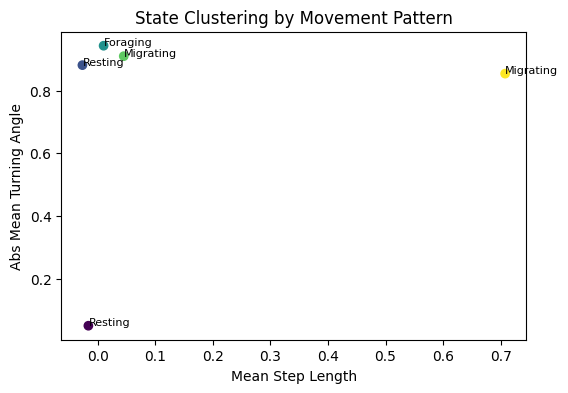


Hidden State Mapping:
State 0 → Resting
State 1 → Foraging
State 2 → Migrating
State 3 → Resting
State 4 → Resting
Model detected 5 or more states — merging into 3 ecological behaviors (Resting, Foraging, Migrating)


In [ ]:
stats_df, predicted_states, state_mapping = interpret_behavioral_states(
    final_model, X_scaled, optimal_n_states, species_list, animal_ids, lengths
)

three_behavior_summary, state_to_behavior = group_states_into_three_behaviors(
    X, predicted_states, lengths
)

In [ ]:
print("DATA-DRIVEN 3-BEHAVIOR GROUPING (Resting/Foraging/Migrating):")
print(three_behavior_summary[['state','n','step_median','speed_median','R_directionality','behavior']])

print("Hidden State Mapping:")
for _, row in three_behavior_summary.sort_values('state').iterrows():
    print(f"State {int(row['state'])} {row['behavior']}")

state_behavior_map_speed, merged_behavior_summary = merge_states_by_speed_and_step(three_behavior_summary)
print("3-behavior merged summary (speed/step rules):")
print(merged_behavior_summary)

DATA-DRIVEN 3-BEHAVIOR GROUPING (Resting/Foraging/Migrating):
   state      n  step_median  speed_median  R_directionality   behavior
0      0   7951     0.044330      8.804125          0.999250    Resting
1      1  54396     0.323633     70.352376          0.132130   Foraging
2      2   1209     4.204114   4204.114064          0.264452  Migrating
3      3     89     0.007284      1.356280          0.030943    Resting
4      4  48092     0.001860      1.860074          0.000000    Resting
Hidden State Mapping:
State 0 Resting
State 1 Foraging
State 2 Migrating
State 3 Resting
State 4 Resting
3-behavior merged summary (speed/step rules):
    behavior  step_median  speed_median  R_directionality      n
0    Resting     0.017825      4.006826          0.343398  56132
1   Foraging     0.323633     70.352376          0.132130  54396
2  Migrating     4.204114   4204.114064          0.264452   1209



BEHAVIORAL STATE INTERPRETATION (Species-Specific Thresholds)

MIXED SPECIES DETECTED: elephant, wildebeest
Using species-specific thresholds for state interpretation
DISCOVERED BEHAVIORAL STATES (Species-Specific Interpretation):

STATE 1 (INTENSITY)
  Step Length: -0.016 ± 0.015 km
  Turning Angle: 0.051 ± 0.067 rad
  Observations: 7,951 (7.1%)

STATE 2 (INTENSITY)
  Step Length: -0.027 ± 0.000 km
  Turning Angle: 0.881 ± 1.010 rad
  Observations: 48,092 (43.0%)

STATE 3 (INTENSITY)
  Step Length: 0.010 ± 0.040 km
  Turning Angle: 0.943 ± 1.062 rad
  Observations: 54,396 (48.7%)

STATE 4 (INTENSITY)
  Step Length: 0.045 ± 0.438 km
  Turning Angle: 0.909 ± 1.036 rad
  Observations: 89 (0.1%)

STATE 5 (INTENSITY)
  Step Length: 0.708 ± 9.581 km
  Turning Angle: 0.854 ± 0.994 rad
  Observations: 1,209 (1.1%)

Grouping similar states into 3 main behavioral categories (species-specific)...
   state  mean_step_length  abs_mean_turning_angle  movement_index  \
0      0         -0.016311   

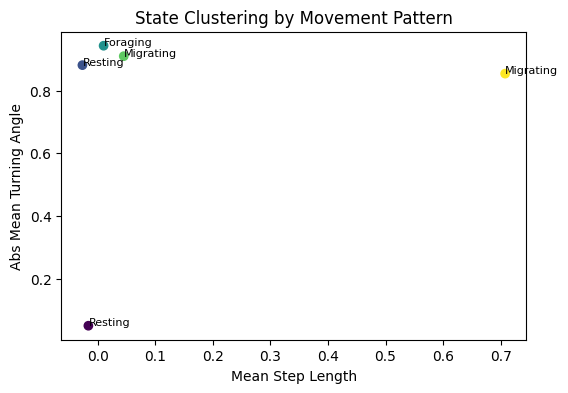


Hidden State Mapping:
State 0 → Resting
State 1 → Foraging
State 2 → Migrating
State 3 → Resting
State 4 → Resting
Model detected 5 or more states — merging into 3 ecological behaviors (Resting, Foraging, Migrating)


In [ ]:
stats_df, predicted_states, state_mapping = interpret_behavioral_states(
    final_model, X_scaled, optimal_n_states, species_list, animal_ids, lengths
)

three_behavior_summary, state_to_behavior = group_states_into_three_behaviors(
    X, predicted_states, lengths
)

In [ ]:
trans_df = analyze_state_transitions(final_model, stats_df)


STATE TRANSITION ANALYSIS

Transition Probability Matrix:
                     State 1 (Intensity)  State 2 (Intensity)  \
State 1 (Intensity)                0.056                0.562   
State 2 (Intensity)                0.032                0.816   
State 3 (Intensity)                0.006                0.741   
State 4 (Intensity)                0.000                0.296   
State 5 (Intensity)                0.116                0.102   

                     State 3 (Intensity)  State 4 (Intensity)  \
State 1 (Intensity)                0.001                0.000   
State 2 (Intensity)                0.017                0.000   
State 3 (Intensity)                0.248                0.006   
State 4 (Intensity)                0.000                0.273   
State 5 (Intensity)                0.000                0.001   

                     State 5 (Intensity)  
State 1 (Intensity)                0.381  
State 2 (Intensity)                0.135  
State 3 (Intensity)           

In [ ]:
individual_states = decode_individual_sequences(final_model, sequences, animal_ids)


DECODING INDIVIDUAL ANIMAL SEQUENCES

LA2:
  Observations: 574
  State 1: 0.2%
  State 2: 0.3%
  State 3: 99.5%

LA5:
  Observations: 67816
  State 1: 0.0%
  State 2: 0.0%
  State 3: 100.0%

W68:
  Observations: 2777
  State 2: 100.0%

W69:
  Observations: 6648
  State 1: 0.0%
  State 2: 63.0%
  State 3: 37.0%

W70:
  Observations: 2895
  State 1: 0.0%
  State 2: 61.9%
  State 3: 38.1%

W71:
  Observations: 113
  State 2: 100.0%

W72:
  Observations: 5021
  State 1: 0.1%
  State 2: 79.7%
  State 3: 20.2%

W77:
  Observations: 5642
  State 1: 0.0%
  State 2: 1.8%
  State 3: 98.2%

W78:
  Observations: 3021
  State 1: 0.1%
  State 2: 61.9%
  State 3: 38.0%

W79:
  Observations: 5207
  State 1: 0.1%
  State 2: 48.0%
  State 3: 51.9%

W80:
  Observations: 5155
  State 1: 0.0%
  State 2: 3.4%
  State 3: 96.5%

W81:
  Observations: 6868
  State 1: 0.0%
  State 2: 8.8%
  State 3: 91.2%


In [ ]:
performance_metrics = calculate_model_performance(final_model, X_scaled, lengths)
# Evaluate model with train/test splits
split_results = evaluate_train_test_split(final_model, X, lengths, animal_ids, scaler, test_size=0.3, random_state=42)


MODEL PERFORMANCE METRICS

Log Likelihood: 848776.43
Per-sample LL: 7.5962
Perplexity: 0.0005
AIC: -1697422.87
BIC: -1696797.32
Number of parameters: 65
Converged: True

CREATING TRAIN/TEST SPLITS AND EVALUATING MODEL
Test size: 30.0%, Random state: 42
Train animals: 8, Test animals: 4
Train: 97780 observations, Test: 13957 observations

TRAIN PERFORMANCE: LL=767370.58, Per-sample=7.8479
TEST PERFORMANCE: LL=81405.86, Per-sample=5.8326
OVERFITTING CHECK: LL difference=2.0153



Generating visualizations...
Saved: hmm_analysis_results.png


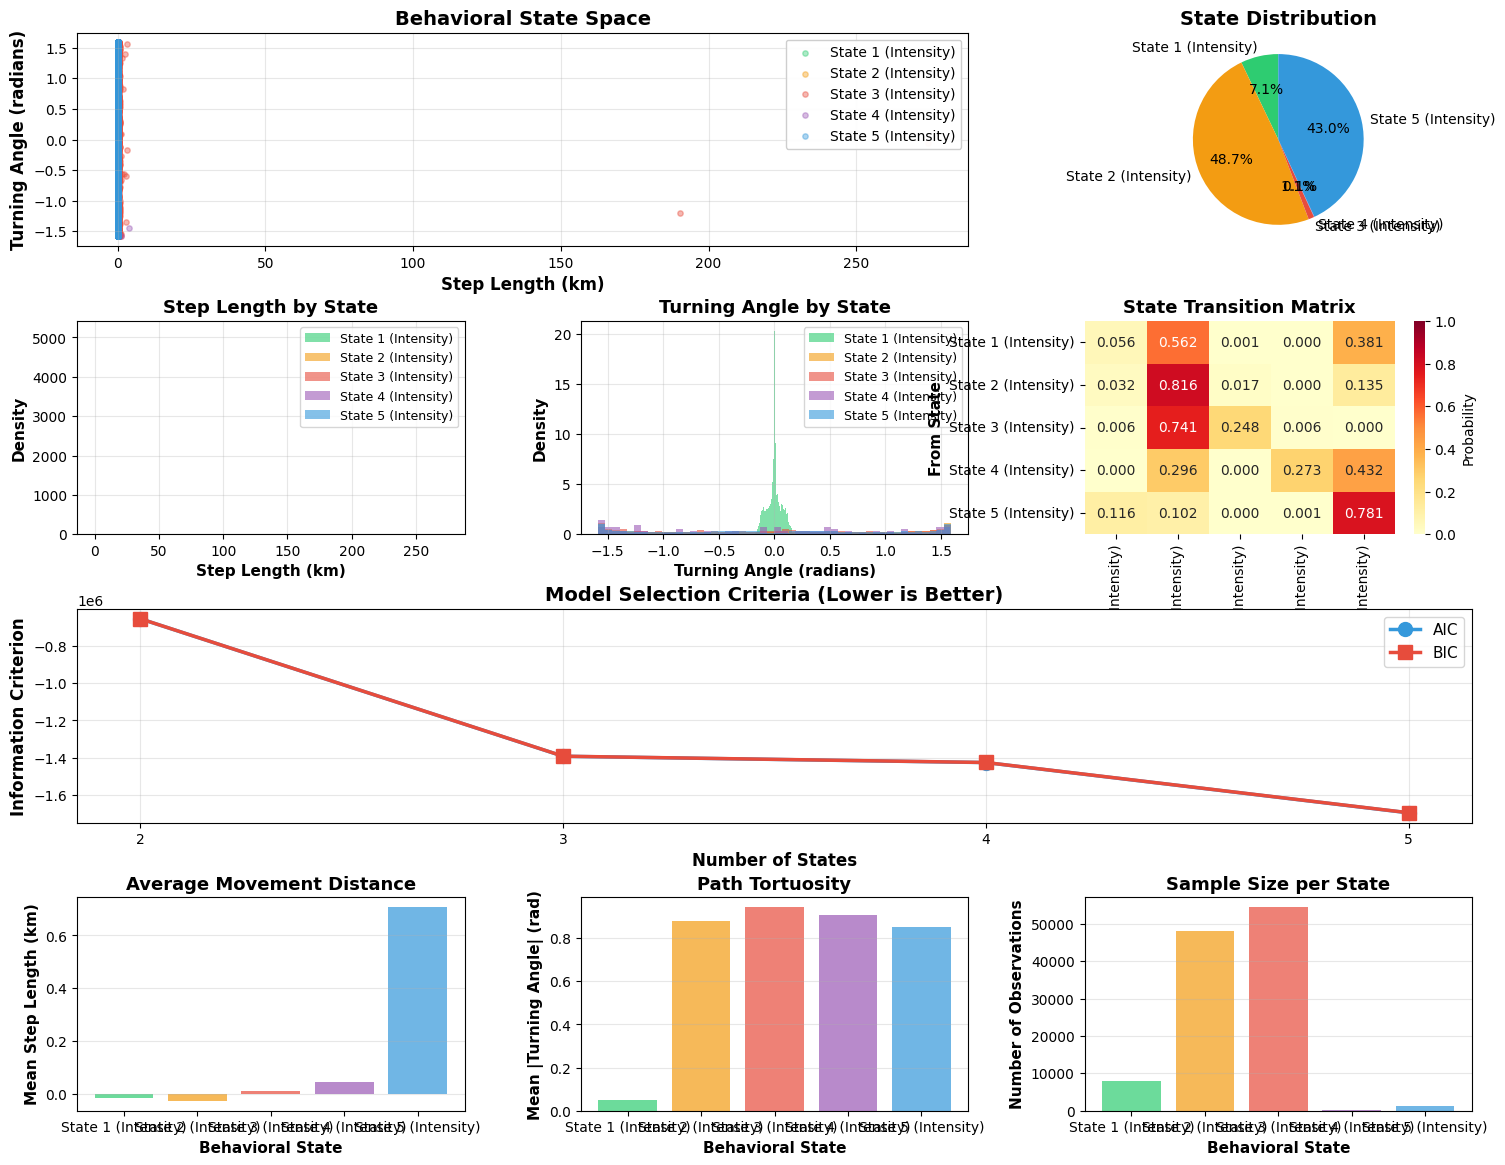

Saved: individual_tracks.png


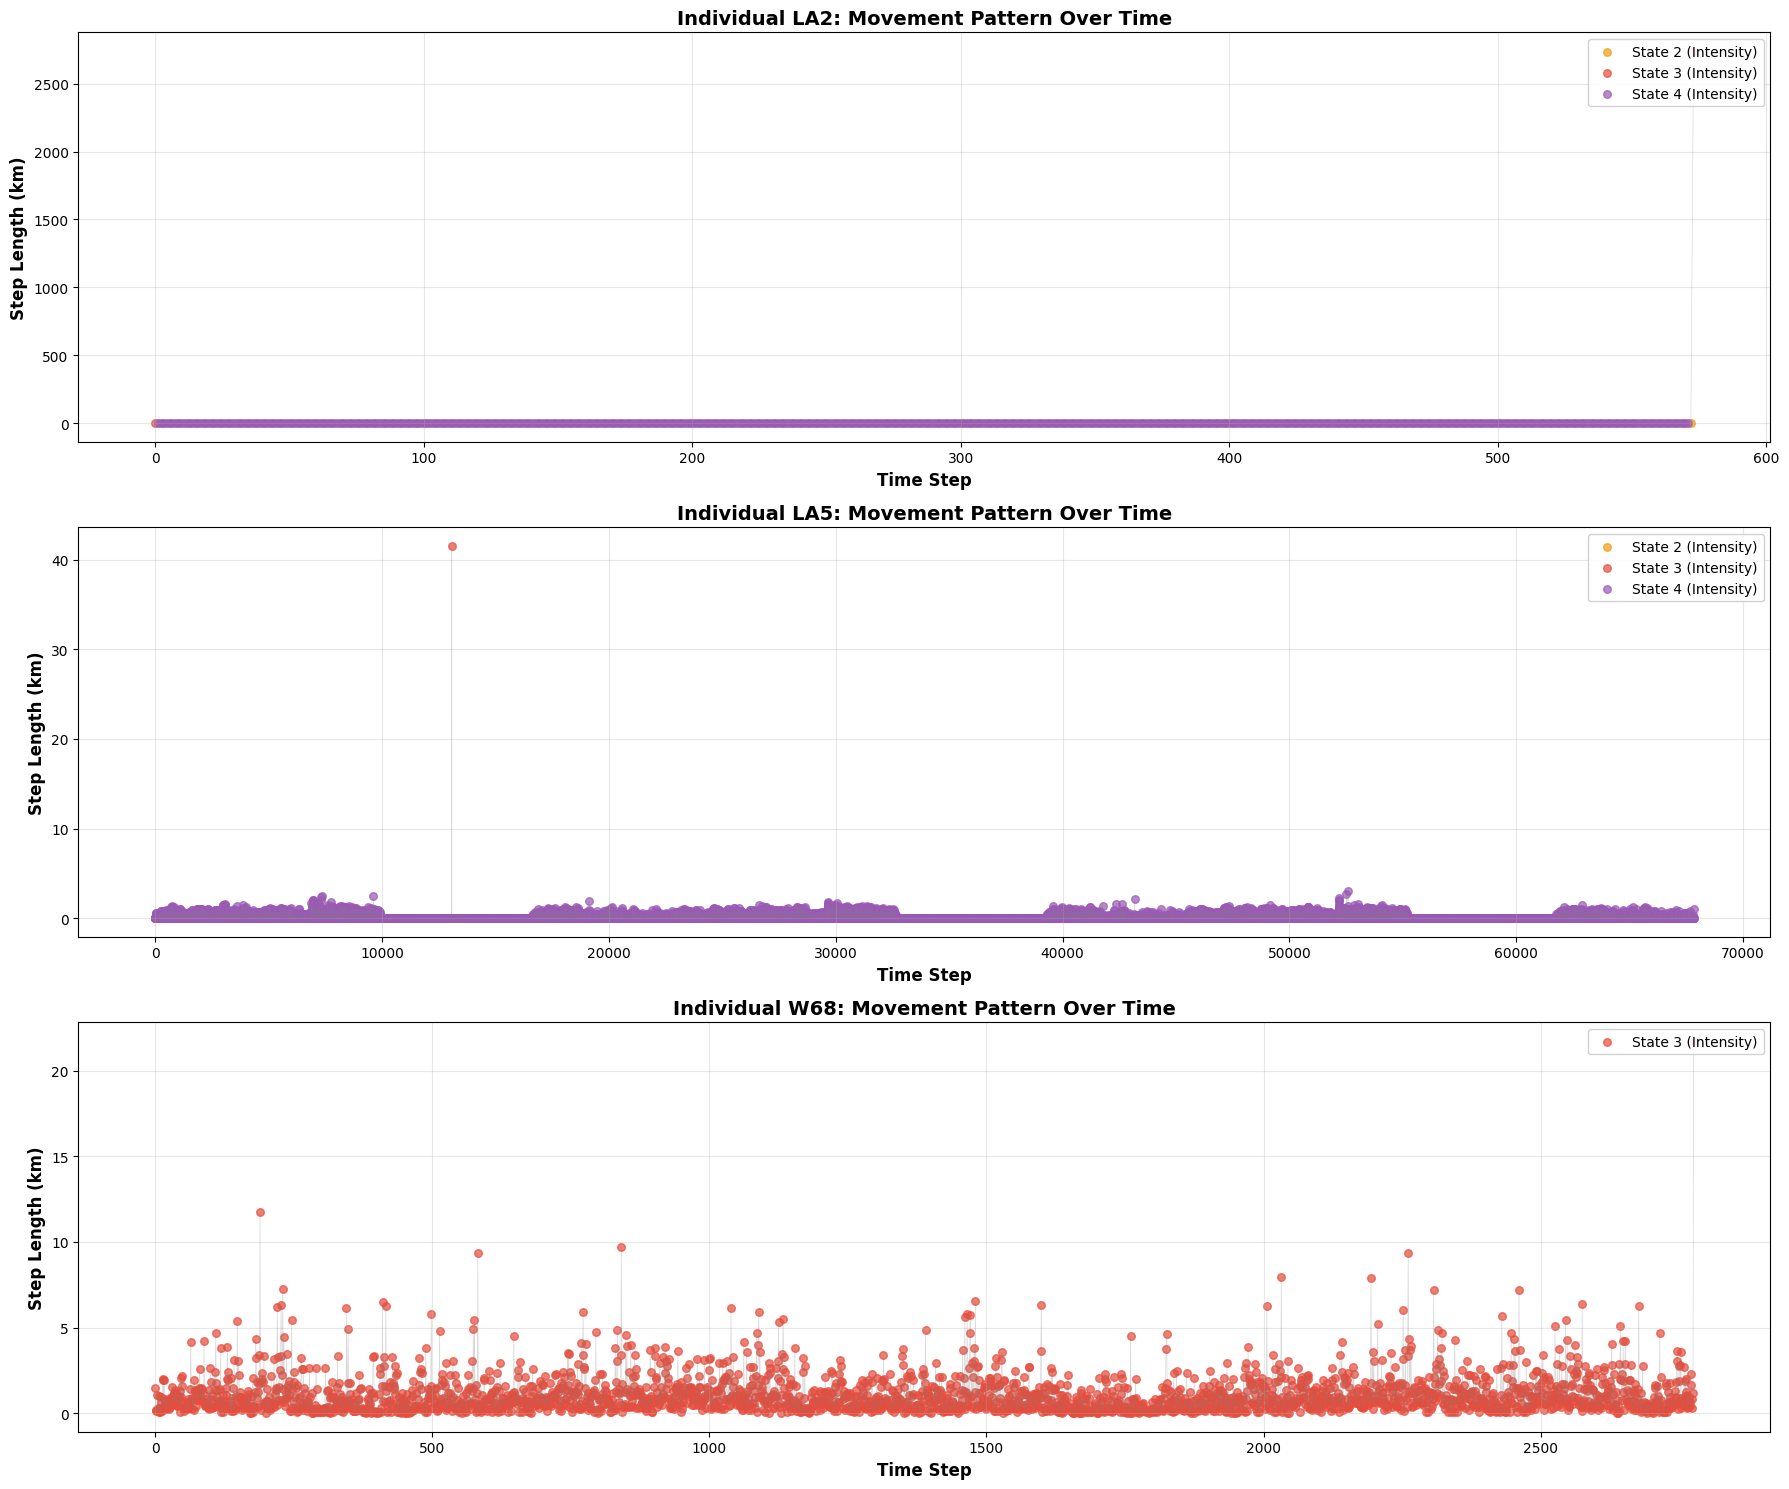

In [ ]:
visualize_model_results(final_model, X_scaled, predicted_states, stats_df, results_df)
visualize_individual_tracks(sequences, individual_states, animal_ids, stats_df, state_mapping, n_display=3)

GENERATING CONFUSION MATRIX AND CLASSIFICATION METRICS
Confusion matrix saved as: hmm_confusion_matrix.png


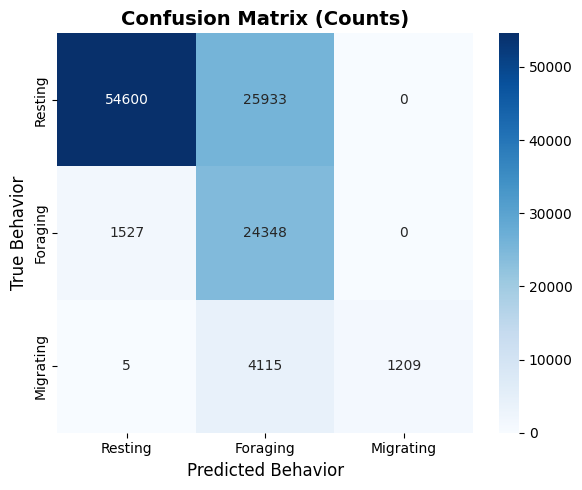


CLASSIFICATION METRICS:
Overall Accuracy: 0.717
Macro Precision: 0.807
Macro Recall: 0.615
Macro F1-Score: 0.592

Per-Class Performance:
   Resting: Precision=0.973, Recall=0.678, F1=0.799, Support=80533
  Foraging: Precision=0.448, Recall=0.941, F1=0.607, Support=25875
 Migrating: Precision=1.000, Recall=0.227, F1=0.370, Support=5329
Saved: hmm_classification_metrics.csv


In [ ]:
# Generate confusion matrix and classification metrics
print("GENERATING CONFUSION MATRIX AND CLASSIFICATION METRICS")

# Create true behavior labels based on step length thresholds
combined_df_subset = combined_df.iloc[:len(predicted_states)].copy()
true_behaviors = generate_true_behavior_labels(combined_df_subset)

# Create confusion matrix
cm, metrics = create_behavior_confusion_matrix(predicted_states, true_behaviors, state_to_behavior)

if cm is not None and metrics is not None:
    behavior_classes = ['Resting', 'Foraging', 'Migrating']

    # Visualize confusion matrix
    visualize_confusion_matrix(cm, behavior_classes, metrics, 'hmm_confusion_matrix.png')

    # Print detailed metrics
    print(f"\nCLASSIFICATION METRICS:")
    print(f"Overall Accuracy: {metrics['accuracy']:.3f}")
    print(f"Macro Precision: {metrics['macro_precision']:.3f}")
    print(f"Macro Recall: {metrics['macro_recall']:.3f}")
    print(f"Macro F1-Score: {metrics['macro_f1']:.3f}")

    print(f"\nPer-Class Performance:")
    for behavior in behavior_classes:
        precision = metrics['precision_per_class'][behavior]
        recall = metrics['recall_per_class'][behavior]
        f1 = metrics['f1_per_class'][behavior]
        support = metrics['support_per_class'][behavior]
        print(f"{behavior:>10}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support}")

    # Save metrics to file
    metrics_df = pd.DataFrame({
        'Behavior': behavior_classes,
        'Precision': [metrics['precision_per_class'][b] for b in behavior_classes],
        'Recall': [metrics['recall_per_class'][b] for b in behavior_classes],
        'F1_Score': [metrics['f1_per_class'][b] for b in behavior_classes],
        'Support': [metrics['support_per_class'][b] for b in behavior_classes]
    })

    metrics_df.to_csv('hmm_classification_metrics.csv', index=False)
    print("Saved: hmm_classification_metrics.csv")
else:
    print("Could not generate confusion matrix - insufficient valid predictions")

In [ ]:
export_results(final_model, stats_df, trans_df, performance_metrics, animal_ids)

try:
    merged_behavior_summary.to_csv('hmm_behavior_summary.csv', index=False)
    print("Saved: hmm_behavior_summary.csv")
    three_behavior_summary.to_csv('hmm_state_summary_raw.csv', index=False)
    print("Saved: hmm_state_summary_raw.csv")
except Exception as e:
    print(f"Could not save merged/raw behavior summaries: {e}")

from scipy.stats import entropy
try:
    behavior_arr = np.array([state_to_behavior.get(int(s), None) for s in predicted_states])
    behavior_idx = pd.Categorical(behavior_arr, categories=['Resting','Foraging','Migrating'], ordered=True).codes
    tm = np.zeros((3, 3), dtype=float)
    for prev, nxt in zip(behavior_idx[:-1], behavior_idx[1:]):
        if prev >= 0 and nxt >= 0:
            tm[prev, nxt] += 1
    tm = tm / np.maximum(tm.sum(axis=1, keepdims=True), 1)
    tm_df_beh = pd.DataFrame(tm, index=['Resting','Foraging','Migrating'], columns=['Resting','Foraging','Migrating'])
    print("Behavior-level transition summary (row-normalized):")
    print(tm_df_beh.round(3))
    tm_df_beh.to_csv('hmm_behavior_transitions.csv')
    print("Saved: hmm_behavior_transitions.csv")
except Exception as e:
    print(f"Skipping behavior-level transition summary: {e}")


EXPORTING RESULTS
Saved: hmm_state_statistics.csv
Saved: hmm_transition_matrix.csv
Saved: hmm_performance_metrics.csv
Saved: hmm_analyzed_animals.csv
Saved: hmm_behavior_summary.csv
Saved: hmm_state_summary_raw.csv
Behavior-level transition summary (row-normalized):
           Resting  Foraging  Migrating
Resting      0.829     0.171      0.000
Foraging     0.176     0.807      0.017
Migrating    0.012     0.746      0.242
Saved: hmm_behavior_transitions.csv


In [ ]:
try:
    state_probs = final_model.predict_proba(X_scaled)
    state_entropy = entropy(state_probs.T)
    max_entropy = np.log(final_model.n_components)
    confidence = 1 - (state_entropy / max_entropy)
    entropy_df = pd.DataFrame({'state_entropy': state_entropy, 'confidence': confidence})
    entropy_df.to_csv('hmm_state_entropy_confidence.csv', index=False)
    print('Saved: hmm_state_entropy_confidence.csv')
except Exception as e:
    print(f"Uncertainty quantification skipped: {e}")

Saved: hmm_state_entropy_confidence.csv


In [ ]:
print("ANALYSIS COMPLETE - SUMMARY")
print(f"Optimal model: {optimal_n_states} behavioral states")
print(f"Total animals analyzed: {len(animal_ids)}")
print(f"Total observations: {len(X):,}")
print(f"Model converged: {final_model.monitor_.converged}")
print(f"Log likelihood: {final_model.score(X_scaled, lengths):.2f}")

print("Discovered States:")
for _, row in stats_df.iterrows():
    print(f"   {row['state_label']}: {row['percentage']:.1f}% of observations")

print("3-behavior grouping per HMM state:")
for _, row in three_behavior_summary.iterrows():
    speed_str = f"{row['speed_median']:.2f}" if pd.notna(row['speed_median']) else 'nan'
    r_str = f"{row['R_directionality']:.3f}" if pd.notna(row['R_directionality']) else 'nan'
    print(f"   State {int(row['state'])}: {row['behavior']} | step={row['step_median']:.3f} km, speed={speed_str} km/h, R={r_str}")


ANALYSIS COMPLETE - SUMMARY
Optimal model: 5 behavioral states
Total animals analyzed: 12
Total observations: 111,737
Model converged: True
Log likelihood: 848776.43
Discovered States:
   State 1 (Intensity): 7.1% of observations
   State 2 (Intensity): 43.0% of observations
   State 3 (Intensity): 48.7% of observations
   State 4 (Intensity): 0.1% of observations
   State 5 (Intensity): 1.1% of observations
3-behavior grouping per HMM state:
   State 0: Resting | step=0.044 km, speed=8.80 km/h, R=0.999
   State 1: Foraging | step=0.324 km, speed=70.35 km/h, R=0.132
   State 2: Migrating | step=4.204 km, speed=4204.11 km/h, R=0.264
   State 3: Resting | step=0.007 km, speed=1.36 km/h, R=0.031
   State 4: Resting | step=0.002 km, speed=1.86 km/h, R=0.000
